In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv


In [2]:
# Load data and shuffle
df_raw = pd.read_csv('/kaggle/input/commonlitreadabilityprize/train.csv').sample(frac=1)
print(df_raw.shape)

df_raw.head()

(2834, 6)


,id,url_legal,license,excerpt,target,standard_error
2108,6b15630fc,NaN,NaN,"I live at No. —— Twenty-sixth Street, in New Y...",-1.768708,0.491556
1253,c913c40e9,NaN,NaN,"The innkeeper cried to them to let him alone, ...",-0.413637,0.495896
745,c376446c9,NaN,NaN,"Almost 3.5 billion years ago, before humans, t...",0.281810,0.481926
1378,749fe0db5,NaN,NaN,I employed all my efforts to prevent the secon...,-2.404343,0.470686
1246,1c7862644,NaN,NaN,A pet grizzly bear had been for a number of ye...,-0.992187,0.484848


In [3]:
# Split into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df_raw['excerpt'],
                                                      df_raw['target'],
                                                      test_size=0.2)

In [4]:
# Load tokenizer
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [12]:
# Get encodings
train_encodings = tokenizer(list(X_train), truncation=True, padding='max_length')
valid_encodings = tokenizer(list(X_valid), truncation=True, padding='max_length')

In [13]:
# Example encoding, no token_type_ids for this transformer
print({'input_ids':train_encodings['input_ids'][0],
       'attention_mask':train_encodings['attention_mask'][0]})

{'input_ids': [101, 1037, 3522, 4045, 2817, 2246, 2012, 1996, 4254, 1997, 2367, 7957, 1997, 9440, 2006, 2119, 2529, 2740, 1998, 1996, 4044, 1005, 1055, 2740, 1012, 2000, 2079, 2023, 2817, 1010, 1996, 6529, 2109, 6747, 1006, 16268, 1007, 2000, 8556, 1996, 6971, 2090, 2321, 2367, 7957, 1997, 9440, 1998, 2274, 8738, 1011, 3141, 2740, 3785, 1998, 2274, 4483, 14670, 1997, 5155, 2122, 9440, 1012, 2005, 2742, 1010, 1996, 6529, 2246, 2012, 2065, 5983, 11546, 2097, 4652, 2149, 2013, 2893, 2540, 4295, 1998, 2129, 2172, 16635, 15865, 2272, 2013, 3652, 11546, 1012, 2027, 2109, 2502, 2951, 4520, 2013, 2060, 2913, 1010, 2029, 2027, 4117, 2478, 1037, 7778, 4118, 2170, 1037, 18804, 12032, 20960, 1012, 1996, 6529, 2179, 2008, 9440, 2008, 2020, 2204, 2005, 2256, 2740, 1010, 2066, 11546, 1010, 10962, 1010, 2878, 17588, 1010, 12264, 1010, 1998, 4190, 17897, 2015, 1010, 2020, 2036, 2204, 2005, 1996, 2740, 1997, 2256, 4774, 1012, 2008, 2003, 1010, 2122, 9440, 2018, 1037, 2659, 4483, 4254, 2006, 2477, 2066, 

In [14]:
# Convert to dataset object
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.values
))

valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_encodings),
    y_valid.values
))

train_dataset

<TensorSliceDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.float64)>

In [15]:
len(train_encodings['input_ids'])

2267

In [72]:
# Fine tune with Trainer / TFTrainer or native Tensorflow
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

# Load model, set up for regression
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                              num_labels=1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)

history = model.fit(train_dataset.batch(16),
                    validation_data=valid_dataset.batch(16),
                    epochs=5)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_119']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/3
142/142 [==============================] - 91s 584ms/step - loss: 0.7701 - mean_absolute_error: 0.6742 - mean_squared_error: 0.7701 - val_loss: 0.3185 - val_mean_absolute_error: 0.4450 - val_mean_squared_error: 0.3185
Epoch 2/3
142/142 [==============================] - 82s 574ms/step - loss: 0.2823 - mean_absolute_error: 0.4208 - mean_squared_error: 0.2823 - val_loss: 0.4031 - val_mean_absolute_error: 0.5093 - val_mean_squared_error: 0.4031
Epoch 3/3
142/142 [==============================] - 82s 574ms/step - loss: 0.2507 - mean_absolute_error: 0.3975 - mean_squared_error: 0.2507 - val_loss: 0.3322 - val_mean_absolute_error: 0.4600 - val_mean_squared_error: 0.3322


In [80]:
pd.DataFrame(history.history)

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
0,0.521999,0.563104,0.521999,0.318472,0.444997,0.318472
1,0.254504,0.399762,0.254504,0.403088,0.509266,0.403088
2,0.197070,0.353397,0.197070,0.332170,0.459983,0.332170


In [81]:
# Load test data
df_test = pd.read_csv('/kaggle/input/commonlitreadabilityprize/test.csv')
df_test

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ..."
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...


In [82]:
# Encode and create dataset, without target column
test_encodings = tokenizer(list(df_test['excerpt']), truncation=True, padding='max_length')

test_data = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings)
))

In [83]:
# Get predictions for test and validation data
test_preds = model.predict(test_data.batch(1))
valid_preds = model.predict(valid_dataset.batch(16))

# Create dataframe with validation predictions vs. actual
df_valid = pd.concat((X_valid,
                      y_valid), axis=1)
df_valid['preds'] = valid_preds.logits # Not actual logits
df_valid.head()

,excerpt,target,preds
2719,Hereupon all the old silver in the colony was ...,-1.221230,-1.277823
2229,Although Greece (or Hel´las) is only half as l...,0.370308,-0.639216
1626,The first glimpse of Mont St. Michel is strang...,-1.121302,-2.008532
1045,"A little later they passed Ladybird. ""Are you ...",0.332933,0.368020
1343,On the morning of the next day the Minister of...,-1.989716,-1.391949


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='preds', ylabel='target'>

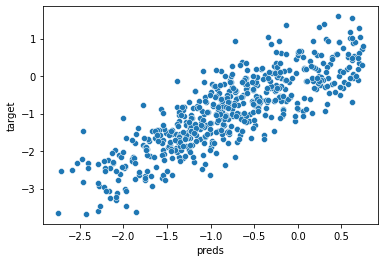

In [84]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.scatterplot(df_valid['preds'], df_valid['target'])

In [86]:
# Print test excerpts and readability
for i in range(df_test.shape[0]):
    print('Text: \n', df_test['excerpt'][i])
    print('Readability predicted score: \n', test_preds.logits[i])
    print('----------------------------------------\n\n')

Text: 
 My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light was visible from the village, but somehow or other I failed to take into account the state of the weather. The air was full of eddying flakes, which would render the headlight of a locomotive invisible a hundred yards distant. Strange that this important fact never occurred to me until I was fully a fourth of a mile from the village. Then, after looking in vain for the beacon light, the danger of my situation struck me, and I halted.
"I am certain to go wrong," I said to myself.
"It is out of my power to follow a direct course without something to serve as a compass. I will go back to the village and wait till morning."
Readability predicted score: 
 [-0.274701]
----------------------------------------


Text: 
 Dotty continued to go to Mrs. Gray's every night with the milk. Sometimes Katie went with her, and then they always paused a 

In [91]:
df_test['id'].values.shape

(7,)

In [96]:
test_preds.logits.flatten()

array([-0.274701  , -0.9015091 , -0.6444819 , -1.8943706 , -1.3738614 ,
       -0.49000093,  0.17791127], dtype=float32)

In [99]:
pd.DataFrame(data={'target':test_preds.logits.flatten()})

,target
0,-0.274701
1,-0.901509
2,-0.644482
3,-1.894371
4,-1.373861
5,-0.490001
6,0.177911


In [113]:
df_submission = pd.DataFrame({'id':df_test['id'].values,
                             'target':test_preds.logits.flatten()})

df_submission

,id,target
0,c0f722661,-0.274701
1,f0953f0a5,-0.901509
2,0df072751,-0.644482
3,04caf4e0c,-1.894371
4,0e63f8bea,-1.373861
5,12537fe78,-0.490001
6,965e592c0,0.177911


In [115]:
df_submission.to_csv('/kaggle/working/submission2.csv', index=False)